<div style="border: 2px solid #FF69B4; background-color: #000000; color: white; padding: 20px; border-radius: 5px;">

# Figure 6

Portrait diagrams

---

 ##### Temperature & Precipitation Indices
---

</div>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
import matplotlib.patches as mpl_patches  # Correct import alias

In [2]:
plotpath = '/work/ab0995/a270229/work/data/paper1/story-nudged/plot/ppr_REV/'

In [3]:
# Function to find variable with time, lat, and lon
def find_variable(ds):
    for var in ds.variables:
        if {'time', 'lat', 'lon'}.issubset(ds[var].dims):
            return var
    return None

In [4]:
indices = ["sdii", "rx1day", "rr1", "rr10", "cdd", "cwd", "fd", "tr", "txn", "txx", "tnn", "tnx"]
regions = [ "SHL", "SML", "TRP", "NML", "NHL", "GLB"]

num_regions = len(regions)
num_indices = len(indices)

# RE

In [5]:
# Paths to data
ptop = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/full_data/hist/processd/etccdi/rdiff/"
pbot = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/full_data/AWICM1/etccdi/rdiff/"

data_top_re = np.full((num_regions, num_indices), np.nan)  # Initialize with NaNs
data_bot_re = np.full((num_regions, num_indices), np.nan)  # Initialize with NaNs

In [6]:
%%time

for i, region in enumerate(regions):
    for j, index in enumerate(indices):
        ftop = f"{ptop}RE_fld1_{index}_{region}.nc"
        fbot = f"{pbot}RE_fld1_{index}_{region}.nc"
        
        try:
            ftop_ds = xr.open_dataset(ftop, decode_times=False)
            fbot_ds = xr.open_dataset(fbot, decode_times=False)
            
            topvar = find_variable(ftop_ds)
            botvar = find_variable(fbot_ds)

            if topvar and botvar:
                dttp = ftop_ds[topvar].values
                dtbt = fbot_ds[botvar].values

                print(region, index, dttp, dtbt)
                data_top_re[i, j] = dttp/100
                data_bot_re[i, j] = dtbt/100

            else:
                print(f"No matching variable found for {index} in {region}")
        except Exception as e:
            print(f"Error processing {index} in {region}: {e}")

SHL sdii [[[0.97161037]]] [[[7.957223]]]
SHL rx1day [[[3.2925355]]] [[[-0.6709723]]]


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


SHL rr1 [[[4.0958347]]] [[[-12.396864]]]
SHL rr10 [[[5.3009977]]] [[[3.0275972]]]
SHL cdd [[[-2.6902108]]] [[[7.6204867]]]
SHL cwd [[[1.3359427]]] [[[-18.443943]]]
SHL fd [[[[-7.523897]]]] [[[4.199768]]]
SHL tr [[[[nan]]]] [[[nan]]]
SHL txn [[[[0.17409354]]]] [[[-1.0433614]]]
SHL txx [[[[0.18501583]]]] [[[-0.8308743]]]
SHL tnn [[[[0.32793167]]]] [[[-0.8827107]]]
SHL tnx [[[[0.36274442]]]] [[[-0.60878515]]]
SML sdii [[[5.004448]]] [[[5.9498615]]]
SML rx1day [[[2.5450175]]] [[[-2.745234]]]
SML rr1 [[[-4.221614]]] [[[-12.169138]]]
SML rr10 [[[-0.7534853]]] [[[2.5389867]]]
SML cdd [[[3.1481903]]] [[[14.158538]]]
SML cwd [[[-6.618415]]] [[[-19.98059]]]
SML fd [[[[-32.694145]]]] [[[97.344505]]]
SML tr [[[[-20.269094]]]] [[[93.430016]]]
SML txn [[[[-0.06284527]]]] [[[-0.06093921]]]
SML txx [[[[-0.11441126]]]] [[[-0.22895455]]]
SML tnn [[[[-0.02938469]]]] [[[-0.04077062]]]
SML tnx [[[[-0.04621736]]]] [[[0.00423659]]]
TRP sdii [[[8.168559]]] [[[18.072954]]]
TRP rx1day [[[-6.624941]]] [[[-31.104

# RMSE

In [7]:
def compute_weighted_rmse_at_each_grid_point_fromdiff(diff: xr.DataArray):
    """
    Compute the area-weighted RMSE at each grid point (lat, lon) across time using the given difference.

    Parameters:
        diff (xarray.DataArray): Difference between observation and model data with dimensions (lat, lon, time)

    Returns:
        xarray.DataArray: RMSE values for each grid point (lat, lon)
    """
    # Compute latitude weights
    lat = diff['lat']
    lat_weights = np.cos(np.deg2rad(lat))  # Cosine weighting
    lat_weights = lat_weights / lat_weights.sum()  # Normalize to sum to 1

    # Convert lat_weights to an xarray DataArray for broadcasting
    lat_weights = xr.DataArray(lat_weights, coords=[lat], dims=["lat"])

    # Compute squared differences (which is already `diff` squared)
    diff_sq = diff ** 2

    # Apply weights to squared differences, sum over the time dimension, and compute the weighted MSE for each grid point
    weighted_mse = (diff_sq * lat_weights).sum(dim="time") / lat_weights.sum()

    # Compute RMSE by taking the square root
    rmse_at_grid_points = np.sqrt(weighted_mse)

    return rmse_at_grid_points

In [8]:
def compute_spatially_averaged_rmse(diff: xr.DataArray):
    """
    Compute a *true* spatially averaged RMSE with latitude-area weighting.
    
    Parameters:
        diff (xarray.DataArray): Model minus observation differences (lat, lon, time).
        
    Returns:
        float: Spatially averaged RMSE.
    """
    # 1. Latitude weights (proportional to grid cell area)
    lat_weights = np.cos(np.deg2rad(diff['lat']))
    lat_weights = lat_weights / lat_weights.sum()  # Normalized to sum=1
    
    # 2. Expand weights to match diff dimensions (lat, lon, time)
    weights = lat_weights.broadcast_like(diff)
    
    # 3. Compute weighted mean of squared differences over space and time
    weighted_mean_sq = (diff**2 * weights).mean(dim=("lat", "lon", "time"))
    
    # 4. Final RMSE
    return np.sqrt(weighted_mean_sq)


In [9]:
pobs = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/full_data/ERA5/ppr_rev/etccdi/rdiff/"
pmod = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/full_data/hist/processd/etccdi/rdiff/"
pawi = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/full_data/AWICM1/etccdi/rdiff/"

data_top_rmse = np.full((num_regions, num_indices), np.nan)  # Initialize with NaNs
data_bot_rmse = np.full((num_regions, num_indices), np.nan)  # Initialize with NaNs

In [10]:
%%time

for i, region in enumerate(regions):
    for j, index in enumerate(indices):
        fmod = f"{pmod}Bias_{index}_2018-2023_{region}.nc"
        fawi = f"{pawi}Bias_{index}_2018-2023_{region}.nc"

        try:
            fmod_ds = xr.open_dataset(fmod, decode_times=False)
            fawi_ds = xr.open_dataset(fawi, decode_times=False)
            
            modvar = find_variable(fmod_ds)
            awivar = find_variable(fawi_ds)
            
            if modvar :
                dtmod = fmod_ds[modvar]
                dtawi = fawi_ds[awivar]

                if 'height' in dtmod.dims:
                    dtmod = dtmod.isel(height=0) #.drop_dims('height')

                dttp=compute_weighted_rmse_at_each_grid_point_fromdiff(dtmod).mean().values
                dtbt=compute_weighted_rmse_at_each_grid_point_fromdiff(dtawi).mean().values

                data_top_rmse[i, j] = dttp
                data_bot_rmse[i, j] = dtbt
                print(region, index, dttp, dtbt)

            else:
                print(f"No matching variable found for {index} in {region}")
        except Exception as e:
            print(f"Error processing {index} in {region}: {e}")

SHL sdii 0.2188080349869966 0.3838027281457324
SHL rx1day 0.8156482214606209 1.5907002601972045


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


SHL rr1 0.9071943160579539 1.3312578106652118
SHL rr10 0.18791881162191443 0.2938624633651691
SHL cdd 1.189300056318424 2.01097519987285
SHL cwd 0.7652001635704777 0.9871025569337004
SHL fd 1.5543810380695904 0.8090800252959525
SHL tr 0.0 0.0
SHL txn 1.3984163478784315 2.0372873446999433
SHL txx 0.6836780376083876 1.6741357189847104
SHL tnn 1.4540793898674025 2.0793721232824414
SHL tnx 0.8655512696360304 1.5454195388019691
SML sdii 0.7850637915401556 1.0176904686762875
SML rx1day 3.935612604437183 5.281607274428445


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


SML rr1 1.1480083194344906 1.7935127910414441
SML rr10 0.5420886791577235 0.7541136941738579
SML cdd 1.0314991845266535 1.4680318026549803
SML cwd 1.1242856945690698 1.4817191766335627
SML fd 0.5926719137788555 0.6839033173287813
SML tr 0.25480117328005386 0.6283908819381534
SML txn 0.5010412496330464 0.7524779600112298
SML txx 0.4613278594152989 0.6929161288294365
SML tnn 0.5245261710345434 0.8829117392794655
SML tnx 0.44022275488189466 0.5848846708747095
TRP sdii 1.0657278122157097 1.3572734345648354
TRP rx1day 6.615224604206656 7.973898142033255


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


TRP rr1 1.2674185667981968 2.2937282035141267
TRP rr10 0.7726022289594888 1.285705643789306
TRP cdd 1.5780494998062597 2.755445915880854
TRP cwd 1.2747311418630394 1.8905805530523
TRP fd 0.02524417469253604 0.031508617386804
TRP tr 0.7616954865755658 0.9928484969020955
TRP txn 0.3424508758618899 0.5508207547578721
TRP txx 0.36402986706064755 0.5955524898403043
TRP tnn 0.3439969014695158 0.6261979922846065
TRP tnx 0.3169958118096229 0.5384004415574247
NML sdii 1.0107526144967316 1.2082426047434995
NML rx1day 4.506806579021789 5.640092565909336


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


NML rr1 1.1121759544889487 1.8676082904068756
NML rr10 0.5888690080803166 0.8197585383510699
NML cdd 1.5386789113594659 2.4030674415355273
NML cwd 0.9289591309955284 1.3196314502876476
NML fd 0.8748550544260435 1.0618572244926323
NML tr 0.7762155657035436 1.3319388257689175
NML txn 0.8019506742718864 1.302089544342595
NML txx 0.8251023147296627 1.2379905091787764
NML tnn 0.9951553298145196 1.5642638719273414
NML tnx 0.757317880362581 1.1553460909074862
NHL sdii 0.38993510255015845 0.6021549941658496
NHL rx1day 1.4719304853586967 2.401343923424192


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


NHL rr1 1.030688786048025 1.5960890324353914
NHL rr10 0.26722703174945206 0.40551438585062216
NHL cdd 1.577591353444507 2.3059338439673853
NHL cwd 0.7292556733819374 1.0190207347339524
NHL fd 1.3502246107999614 2.4405159595536805
NHL tr 0.011336292931499917 0.057392182764321134
NHL txn 1.311509386651435 2.0412054458157556
NHL txx 0.9839554554478731 1.5450164032834883
NHL tnn 1.353077541059462 2.240471075775408
NHL tnx 0.98186662205918 1.3975886163557363


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


GLB sdii 0.40546555232988035 0.5211230846616768


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


GLB rx1day 2.259671355257604 2.8301673876251416


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


GLB rr1 0.5435320280170584 0.9279999469485297
GLB rr10 0.2821901312843272 0.44512954473707034


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


GLB cdd 0.6747033751784859 1.1119024407050397


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


GLB cwd 0.511333462132947 0.7318867145427548
GLB fd 0.23588426984673816 0.2721517741388131
GLB tr 0.2533686444601504 0.37601700778558617


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


GLB txn 0.29067092121604265 0.4524307734781653


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


GLB txx 0.24952523055354695 0.4170088731741342


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


GLB tnn 0.3106431917439167 0.5085913473794617


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


GLB tnx 0.23989567420545277 0.3780697874085509
CPU times: user 3min 12s, sys: 3min 45s, total: 6min 58s
Wall time: 9min 33s


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [9]:
%%time

for i, region in enumerate(regions):
    for j, index in enumerate(indices):
        fmod = f"{pmod}Bias_{index}_2018-2023_{region}.nc"
        fawi = f"{pawi}Bias_{index}_2018-2023_{region}.nc"

        try:
            fmod_ds = xr.open_dataset(fmod, decode_times=False)
            fawi_ds = xr.open_dataset(fawi, decode_times=False)
            
            modvar = find_variable(fmod_ds)
            awivar = find_variable(fawi_ds)
            
            if modvar :
                dtmod = fmod_ds[modvar]
                dtawi = fawi_ds[awivar]

                if 'height' in dtmod.dims:
                    dtmod = dtmod.isel(height=0) #.drop_dims('height')

                dttp = compute_spatially_averaged_rmse(dtmod).values
                dtbt = compute_spatially_averaged_rmse(dtawi).values

                data_top_rmse[i, j] = dttp
                data_bot_rmse[i, j] = dtbt
                print(region, index, dttp, dtbt)

            else:
                print(f"No matching variable found for {index} in {region}")
        except Exception as e:
            print(f"Error processing {index} in {region}: {e}")

SHL sdii 0.04130920173496754 0.07798914576711463
SHL rx1day 0.1402429433666209 0.2559065039456978


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


SHL rr1 0.1517522619363999 0.19791947936559504
SHL rr10 0.033942401484468074 0.05480332503218843
SHL cdd 0.15581819645364145 0.2615769626735786
SHL cwd 0.13393384221781848 0.16034765993050323
SHL fd 0.32965700359491196 0.2061689026612963
SHL tr 0.0 0.0
SHL txn 0.21184752405932608 0.26942387650070754
SHL txx 0.0915986550054331 0.22770388388739696
SHL tnn 0.22102855623783157 0.28360377459446867
SHL tnx 0.1170275141005806 0.20099430884542158
SML sdii 0.11894814004677502 0.1440433333979632
SML rx1day 0.573356646637118 0.7120051413494525


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


SML rr1 0.13846774517135832 0.2155238443742494
SML rr10 0.0673181570846421 0.09379695188087231
SML cdd 0.1412456590585113 0.20209748523849735
SML cwd 0.14197618367029807 0.18816077426378833
SML fd 0.13034390777958146 0.14606635211618993
SML tr 0.06105428750215348 0.15024212971517079
SML txn 0.06612319821770257 0.10191244568641282
SML txx 0.060987584662627096 0.09479902710621546
SML tnn 0.07089628337407212 0.1181214540518964
SML tnx 0.05557427542215388 0.08067742502759111
TRP sdii 0.15614078044114832 0.22093922491173465
TRP rx1day 0.9302798712667796 1.1165944384295141


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


TRP rr1 0.16469323604161126 0.30358767267665304
TRP rr10 0.11031971020490725 0.19209385418265368
TRP cdd 0.20501967382463226 0.3585887722622795
TRP cwd 0.17736406271023608 0.2653202846454999
TRP fd 0.021364877697113694 0.03200983334873094
TRP tr 0.14698664900480427 0.19439037746559537
TRP txn 0.048577288492734697 0.07659149769356866
TRP txx 0.05165904171773784 0.08573470366970441
TRP tnn 0.04609468993324846 0.08405307289139315
TRP tnx 0.0429273368339348 0.07359297046539814
NML sdii 0.13928518333785986 0.17046958680800295
NML rx1day 0.6254333738823922 0.7574647236384892


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


NML rr1 0.13811340446810766 0.23186980167418686
NML rr10 0.076100682833988 0.10723739902131492
NML cdd 0.2006073030758118 0.317872287986547
NML cwd 0.12182271190126553 0.17125842018033782
NML fd 0.13685251659222336 0.17715538367123948
NML tr 0.140878322819309 0.2242245936455958
NML txn 0.10603226656630745 0.16890358810550718
NML txx 0.10901606304270157 0.16698453266690627
NML tnn 0.13621083929210917 0.20781971733208437
NML tnx 0.0985431528412155 0.15510649456636058
NHL sdii 0.05716442108632248 0.08936743326574594
NHL rx1day 0.22322083711262264 0.3573448378270211


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


NHL rr1 0.14260528887139975 0.21525177602493617
NHL rr10 0.042037902978722175 0.0649992752541752
NHL cdd 0.19771287858572845 0.2881331400526926
NHL cwd 0.10849117758756266 0.14832608437810546
NHL fd 0.20500064750690658 0.3234834566336453
NHL tr 0.006319901928821973 0.020948886806987862
NHL txn 0.1749133996554878 0.2612264821351398
NHL txx 0.12980004208640092 0.20834550941003518
NHL tnn 0.18348190793020402 0.28549480787977766
NHL tnx 0.1264720408201651 0.18139352582547832
GLB sdii 0.07059960344792211 0.0948159105481701
GLB rx1day 0.408501191385526 0.4927187390710305


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


GLB rr1 0.0785426736414776 0.1391486901113753
GLB rr10 0.04872814662821601 0.08273821252710055
GLB cdd 0.09769934617804137 0.16564193671083485
GLB cwd 0.08147974813104636 0.11929790362770942
GLB fd 0.05339889620951663 0.05851057836840411
GLB tr 0.06570775257632434 0.09230057161699447
GLB txn 0.04139650046591597 0.06113644116603558
GLB txx 0.03467272108236677 0.058416566999457485
GLB tnn 0.044671487893487176 0.06876144184455857
GLB tnx 0.032081926879425716 0.05151189856885555
CPU times: user 3min 1s, sys: 3min 8s, total: 6min 10s
Wall time: 8min 29s


# Pattern Correlation

In [11]:
# Calculate correlation coefficient along the time dimension separately for each time step
def calculate_correlation(dataset1, dataset2):
    correlation_values = []
    for t in range(len(dataset1['time'])):
        # Select the data at a specific time step
        data1 = dataset1.isel(time=t)
        data2 = dataset2.isel(time=t)

        # Check if the data is 1D or 2D and flatten accordingly
        if data1.values.ndim == 1:
            valid_mask = ~np.isnan(data1.values) & ~np.isnan(data2.values)
            valid_data1 = data1.values[valid_mask]
            valid_data2 = data2.values[valid_mask]
        elif data1.values.ndim == 2:
            valid_mask = ~np.isnan(data1.values) & ~np.isnan(data2.values)
            valid_data1 = data1.values.flatten()[valid_mask.flatten()]
            valid_data2 = data2.values.flatten()[valid_mask.flatten()]

        # Check if there's enough data to compute correlation
        if len(valid_data1) > 1 and len(valid_data2) > 1:
            # Calculate correlation coefficient using only valid data
            correlation = np.corrcoef(valid_data1, valid_data2)[0, 1]
        else:
            # If there are not enough valid data points, set correlation to NaN
            correlation = np.nan

        correlation_values.append(correlation)

    # Construct a new DataArray with time coordinates and correlation values
    correlation = xr.DataArray(
        correlation_values,
        coords=[dataset1.time],
        dims=['time'],
        name='correlation'
    )

    return correlation

In [12]:
pobs = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/full_data/ERA5/ppr_rev/etccdi/"
pmod = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/full_data/hist/processd/etccdi/"
pawi = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/full_data/AWICM1/etccdi/"

data_top_pcor = np.full((num_regions, num_indices), np.nan)  # Initialize with NaNs
data_bot_pcor = np.full((num_regions, num_indices), np.nan)  # Initialize with NaNs

In [13]:
%%time

for i, region in enumerate(regions):
    for j, index in enumerate(indices):
        fmod = f"{pmod}{index}_2018-2023_{region}.nc"
        fawi = f"{pawi}{index}_2018-2023_{region}.nc"
        fobs = f"{pobs}{index}_2018-2023_{region}.nc"

        try:
            fmod_ds = xr.open_dataset(fmod, decode_times=False)
            fawi_ds = xr.open_dataset(fawi, decode_times=False)
            fobs_ds = xr.open_dataset(fobs, decode_times=False)
            
            modvar = find_variable(fmod_ds)
            awivar = find_variable(fawi_ds)
            obsvar = find_variable(fobs_ds)
            
            if modvar :
                dtmod = fmod_ds[modvar]
                dtawi = fawi_ds[awivar]
                dtobs = fobs_ds[obsvar]

                if 'height' in dtmod.dims:
                    dtmod = dtmod.isel(height=0) #.drop_dims('height')

                dttp = calculate_correlation(dtmod,dtobs).mean().values
                dtbt = calculate_correlation(dtawi,dtobs).mean().values
                
                data_top_pcor[i, j] = dttp
                data_bot_pcor[i, j] = dtbt
                print(region, index, dttp, dtbt)

            else:
                print(f"No matching variable found for {index} in {region}")
        except Exception as e:
            print(f"Error processing {index} in {region}: {e}")

SHL sdii 0.923628367423508 0.688402360841308
SHL rx1day 0.9506834839421556 0.8026140176164714


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


SHL rr1 0.9632381110902922 0.9329685753785188
SHL rr10 0.870658260838546 0.6090142151204139
SHL cdd 0.9630759713508937 0.8870370077970541
SHL cwd 0.8513322509182042 0.7647502276486249
SHL fd 0.8553693909628798 0.8395469752802375


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


SHL tr nan nan
SHL txn 0.98950207628971 0.9830490991776877
SHL txx 0.9959168004962338 0.9837462139503638
SHL tnn 0.9889195333924319 0.9798203480295773
SHL tnx 0.9952640464295825 0.9841330696049909
SML sdii 0.8241787760100276 0.6509432599472169
SML rx1day 0.7754038715072608 0.5504505840609322


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


SML rr1 0.9280566408073708 0.8498260264813556
SML rr10 0.8110405048579623 0.615561572294901
SML cdd 0.8654147234718746 0.7702714626012047
SML cwd 0.7587106178066974 0.5633603401979389
SML fd 0.8055970654467385 0.9035856109920744
SML tr 0.9017609658601712 0.8519091270048329
SML txn 0.9880598553503531 0.9742707171726559
SML txx 0.9920855279500734 0.9807436452235354
SML tnn 0.9855490270333342 0.9691313289238843
SML tnx 0.9916980519628685 0.981399485483384
TRP sdii 0.7432297464700144 0.4511302391959042
TRP rx1day 0.6775267694279076 0.49087564348297086


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


TRP rr1 0.9139493859043747 0.7337857315168983
TRP rr10 0.8275405621566967 0.6098426771761264
TRP cdd 0.876863804004577 0.6711629304956469
TRP cwd 0.7864598652863131 0.6013342446857468
TRP fd 0.9384020199330286 0.8490832206820604
TRP tr 0.9495868038038213 0.8990209298029872
TRP txn 0.9660422493976394 0.9185870972114327
TRP txx 0.9680296010364428 0.910844493478426
TRP tnn 0.9812147288028616 0.9425691251571178
TRP tnx 0.9681613308952028 0.923086300401424
NML sdii 0.8180820236589972 0.6432343679506674
NML rx1day 0.8155391678501707 0.6459046663392678


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


NML rr1 0.9356935984496155 0.8292971262754651
NML rr10 0.8570547104237057 0.7214055789349885
NML cdd 0.8944538846167388 0.7687578275862899
NML cwd 0.8053179399381534 0.6267808010907837
NML fd 0.9482028433493799 0.8718228772743337
NML tr 0.9203057402116196 0.891731155206728
NML txn 0.9833084919140512 0.9542559815311262
NML txx 0.9783200942926749 0.9487090299798303
NML tnn 0.9806611708340532 0.9410068466779431
NML tnx 0.9788142475301621 0.9406137898889269
NHL sdii 0.893341174110836 0.7171155393797234
NHL rx1day 0.8971486511245319 0.7029249926116702


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


NHL rr1 0.904576147002028 0.7762927250588448
NHL rr10 0.8702481597507074 0.7103339433584694
NHL cdd 0.8351141856556674 0.6361946790178638
NHL cwd 0.7804161363903401 0.5914841625900311
NHL fd 0.9299053730042321 0.8572871501291949


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


NHL tr 0.42885123507334283 0.28718322833365917
NHL txn 0.95676327175106 0.9028259622401943
NHL txx 0.9764091529345927 0.9265037290758086
NHL tnn 0.948613459695151 0.8701677855216022
NHL tnx 0.9659222726804821 0.9287495446299646
GLB sdii 0.8092131062699234 0.6180754545791469
GLB rx1day 0.7398799949268513 0.5629250232058265


/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 0-0-64 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000-0-64 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


GLB rr1 0.9351832235290272 0.8123917771757719
GLB rr10 0.8524944680421884 0.6663729511412448
GLB cdd 0.9112711746891313 0.7705247811682793
GLB cwd 0.8098118564266241 0.6297156929474776
GLB fd 0.9802266377391544 0.9654599198468089
GLB tr 0.9849104048569551 0.970523102237382
GLB txn 0.9960482081793843 0.9922376264189521
GLB txx 0.9962878334257584 0.9907039784346399
GLB tnn 0.9955033237821398 0.9898736828442354
GLB tnx 0.9962239360749925 0.9924399484985398
CPU times: user 7min 6s, sys: 6min 14s, total: 13min 21s
Wall time: 16min 57s


# Plotting

In [15]:
data_top1 = data_top_rmse 
data_bot1 = data_bot_rmse

data_top2 = data_top_pcor
data_bot2 = data_bot_pcor

/tmp/ipykernel_3764425/1394750125.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make room for colorbar


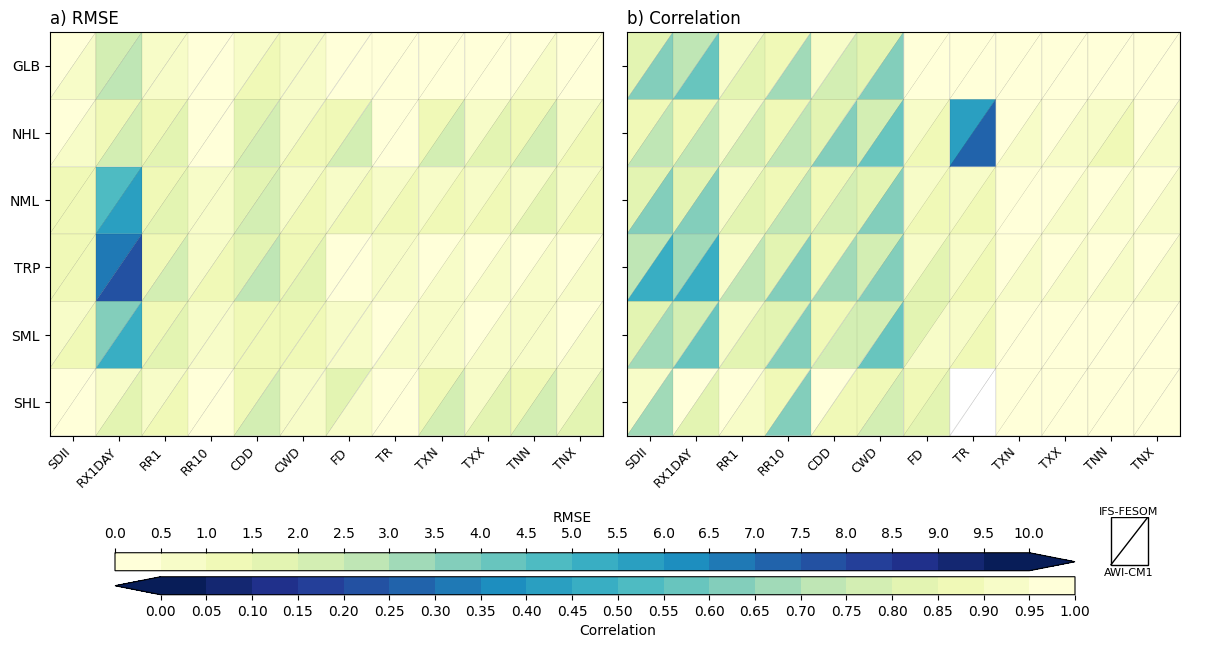

In [31]:
# # Create Figure two colorbars
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Two subplots
# ax1, ax2 = axes  # Assign axes handles

# triangle_patches1 = []  # Stores all triangle patches for the first plot
# colors1 = []   # Stores color values for each triangle

# triangle_patches2 = []  # Stores all triangle patches for the second plot
# colors2 = []   # Stores color values for each triangle

# # Define common grid for both heatmaps
# for i in range(num_regions):
#     for j in range(num_indices):
#         x, y = j, i  # Grid coordinates

#         # Define triangles
#         top_triangle = [(x, y), (x, y + 1), (x + 1, y + 1)]
#         bottom_triangle = [(x, y), (x + 1, y + 1), (x + 1, y)]

#         # First Heatmap Data
#         triangle_patches1.append(Polygon(top_triangle, closed=True))
#         triangle_patches1.append(Polygon(bottom_triangle, closed=True))
#         colors1.append(data_top1[i, j])
#         colors1.append(data_bot1[i, j])

#         # Second Heatmap Data
#         triangle_patches2.append(Polygon(top_triangle, closed=True))
#         triangle_patches2.append(Polygon(bottom_triangle, closed=True))
#         colors2.append(data_top2[i, j])
#         colors2.append(data_bot2[i, j])

# # Define color boundaries and colormap for the FIRST heatmap
# bounds1 = np.arange(0, 10.5, 0.5)  # Example range - Adjust as needed
# cmap1 = plt.get_cmap('YlGnBu', len(bounds1) - 1)  # Discrete colormap for the first plot
# norm1 = BoundaryNorm(bounds1, cmap1.N)

# # Create patch collection for the first heatmap
# collection1 = PatchCollection(triangle_patches1, edgecolor='black', linewidth=0.05, cmap=cmap1, norm=norm1)
# collection1.set_array(np.array(colors1))
# collection1.set_clim(bounds1[0], bounds1[-1])

# ax1.add_collection(collection1)
# ax1.set_title('a) RMSE', fontsize=12, loc='left')
# ax1.set_xticks(np.arange(num_indices) + 0.5)
# # ax1.set_xticklabels(indices, rotation=45, ha="right", fontsize=9)
# ax1.set_xticklabels([i.upper() for i in indices], rotation=45, ha="right", fontsize=9)
# ax1.set_yticks(np.arange(num_regions) + 0.5)
# ax1.set_yticklabels(regions, fontsize=10)  # Reverse the order of regions
# ax1.set_xlim(0, num_indices)
# ax1.set_ylim(0, num_regions)
# # ax1.invert_yaxis()

# # Define color boundaries and colormap for the SECOND heatmap
# bounds2 = np.arange(0, 1.05, 0.05)  # Example range - Adjust as needed
# cmap2 = plt.get_cmap('YlGnBu_r', len(bounds2) - 1)  # Discrete colormap for the second plot
# norm2 = BoundaryNorm(bounds2, cmap2.N)

# # Create patch collection for the second heatmap
# collection2 = PatchCollection(triangle_patches2, edgecolor='black', linewidth=0.05, cmap=cmap2, norm=norm2)
# collection2.set_array(np.array(colors2))
# collection2.set_clim(bounds2[0], bounds2[-1])

# ax2.add_collection(collection2)
# ax2.set_title('b) Correlation', fontsize=12, loc='left')
# ax2.set_xticks(np.arange(num_indices) + 0.5)
# # ax2.set_xticklabels(indices, rotation=45, ha="right", fontsize=9)
# ax2.set_xticklabels([i.upper() for i in indices], rotation=45, ha="right", fontsize=9)
# ax2.set_yticks(np.arange(num_regions) + 0.5)
# ax2.set_yticklabels([]) #  Remove row labels for the second heatmap
# ax2.set_xlim(0, num_indices)
# ax2.set_ylim(0, num_regions)
# # ax2.invert_yaxis()

# # Add Colorbar for the FIRST heatmap
# cbar_ax1 = fig.add_axes([0.1, -0.01, 0.8, 0.03])  # Position: [left, bottom, width, height]
# cbar1 = plt.colorbar(collection1, cax=cbar_ax1, orientation="horizontal", ticks=bounds1, extend='max')
# cbar1.set_label("RMSE", fontsize=10)
# cbar1.ax.xaxis.set_ticks_position('top')  # Move ticks to the top
# cbar1.ax.xaxis.set_label_position('top')  # Move label to the top
# cbar1.ax.tick_params(axis='x', pad=5)

# # Add Legend to the right of the colorbar
# legend_ax = fig.add_axes([0.92, -0.02, 0.1, 0.1])  # [left, bottom, width, height]
# legend_ax.axis('off')  # Turn off axes for the legend

# # Draw the rectangle
# rect_x = 0.1  # Starting x-coordinate
# rect_y = 0.2  # Starting y-coordinate
# rect_width = 0.31 # Width of the rectangle
# rect_height = 0.8  # Height of the rectangle
# rect = mpl_patches.Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=1, edgecolor='black', facecolor='white', transform=legend_ax.transAxes)
# legend_ax.add_patch(rect)

# # Draw the diagonal line
# line_start_x = rect_x
# line_start_y = rect_y
# line_end_x = rect_x + rect_width
# line_end_y = rect_y + rect_height
# line = plt.Line2D([line_start_x, line_end_x], [line_start_y, line_end_y], transform=legend_ax.transAxes, linewidth=1.0, color='black')
# legend_ax.add_line(line)

# # Add text labels
# legend_ax.text(0.25, 1.0, 'IFS-FESOM', ha='center', va='bottom', fontsize=8, transform=legend_ax.transAxes)
# legend_ax.text(0.25, 0.15, 'AWI-CM1', ha='center', va='top', fontsize=8, transform=legend_ax.transAxes)


# # Add Colorbar for the SECOND heatmap
# cbar_ax2 = fig.add_axes([0.1, -0.05, 0.8, 0.03])  # Position: [left, bottom, width, height]
# cbar2 = plt.colorbar(collection2, cax=cbar_ax2, orientation="horizontal", ticks=bounds2, extend='min')
# cbar2.set_label("Correlation", fontsize=10)


# plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make room for colorbar
# # plt.savefig(f'{plotpath}/rmse_corr_portain_2xcbar.png', dpi=500, bbox_inches='tight')
# plt.show()


NameError: name 'data_top1' is not defined

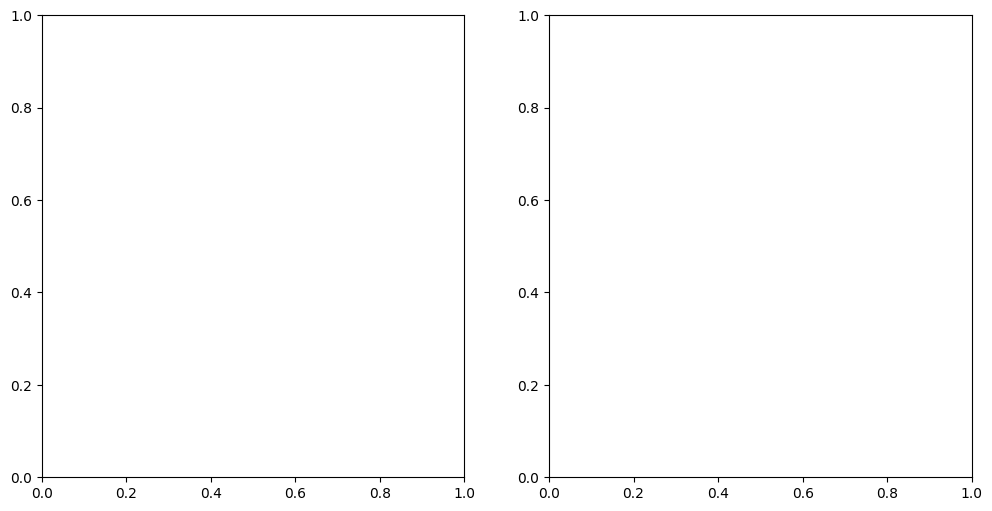

In [5]:

# Create Figure two colorbars
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Two subplots
ax1, ax2 = axes  # Assign axes handles

triangle_patches1 = []  # Stores all triangle patches for the first plot
colors1 = []   # Stores color values for each triangle

triangle_patches2 = []  # Stores all triangle patches for the second plot
colors2 = []   # Stores color values for each triangle

# Define common grid for both heatmaps
for i in range(num_regions):
    for j in range(num_indices):
        x, y = j, i  # Grid coordinates

        # Define triangles
        top_triangle = [(x, y), (x, y + 1), (x + 1, y + 1)]
        bottom_triangle = [(x, y), (x + 1, y + 1), (x + 1, y)]

        # First Heatmap Data
        triangle_patches1.append(Polygon(top_triangle, closed=True))
        triangle_patches1.append(Polygon(bottom_triangle, closed=True))
        colors1.append(data_top1[i, j])
        colors1.append(data_bot1[i, j])

        # Second Heatmap Data
        triangle_patches2.append(Polygon(top_triangle, closed=True))
        triangle_patches2.append(Polygon(bottom_triangle, closed=True))
        colors2.append(data_top2[i, j])
        colors2.append(data_bot2[i, j])

# Define color boundaries and colormap for the FIRST heatmap
bounds1 = np.arange(0, 10.5, 0.5)  # Example range - Adjust as needed
cmap1 = plt.get_cmap('YlGnBu', len(bounds1) - 1)  # Discrete colormap for the first plot
norm1 = BoundaryNorm(bounds1, cmap1.N)

# Create patch collection for the first heatmap
collection1 = PatchCollection(triangle_patches1, edgecolor='black', linewidth=0.05, cmap=cmap1, norm=norm1)
collection1.set_array(np.array(colors1))
collection1.set_clim(bounds1[0], bounds1[-1])

ax1.add_collection(collection1)
# ax1.set_title('a) RMSE', fontsize=12, loc='left')
ax1.set_xticks(np.arange(num_indices) + 0.5)
ax1.set_xticklabels(indices, rotation=45, ha="right", fontsize=9)
# ax1.set_xticklabels([i.upper() for i in indices], rotation=45, ha="right", fontsize=9)
ax1.set_yticks(np.arange(num_regions) + 0.5)
ax1.set_yticklabels(regions, fontsize=10)  # Reverse the order of regions
ax1.set_xlim(0, num_indices)
ax1.set_ylim(0, num_regions)
# ax1.invert_yaxis()

# Define color boundaries and colormap for the SECOND heatmap
bounds2 = np.arange(0, 1.05, 0.05)  # Example range - Adjust as needed
cmap2 = plt.get_cmap('YlGnBu_r', len(bounds2) - 1)  # Discrete colormap for the second plot
norm2 = BoundaryNorm(bounds2, cmap2.N)

# Create patch collection for the second heatmap
collection2 = PatchCollection(triangle_patches2, edgecolor='black', linewidth=0.05, cmap=cmap2, norm=norm2)
collection2.set_array(np.array(colors2))
collection2.set_clim(bounds2[0], bounds2[-1])

ax2.add_collection(collection2)
# ax2.set_title('b) Correlation', fontsize=12, loc='left')
ax2.set_xticks(np.arange(num_indices) + 0.5)
ax2.set_xticklabels(indices, rotation=45, ha="right", fontsize=9)
# ax2.set_xticklabels([i.upper() for i in indices], rotation=45, ha="right", fontsize=9) # for caps
ax2.set_yticks(np.arange(num_regions) + 0.5)
ax2.set_yticklabels([]) #  Remove row labels for the second heatmap
ax2.set_xlim(0, num_indices)
ax2.set_ylim(0, num_regions)
# ax2.invert_yaxis()

# Add Colorbar for the FIRST heatmap
cbar_ax1 = fig.add_axes([0.1, -0.01, 0.8, 0.03])  # Position: [left, bottom, width, height]
cbar1 = plt.colorbar(collection1, cax=cbar_ax1, orientation="horizontal", ticks=bounds1, extend='max')
cbar1.set_label("RMSE", fontsize=10)
cbar1.ax.xaxis.set_ticks_position('top')  # Move ticks to the top
cbar1.ax.xaxis.set_label_position('top')  # Move label to the top
cbar1.ax.tick_params(axis='x', pad=5)

# Add Legend to the right of the colorbar
legend_ax = fig.add_axes([0.92, -0.02, 0.1, 0.1])  # [left, bottom, width, height]
legend_ax.axis('off')  # Turn off axes for the legend

# Draw the rectangle
rect_x = 0.1  # Starting x-coordinate
rect_y = 0.2  # Starting y-coordinate
rect_width = 0.31 # Width of the rectangle
rect_height = 0.8  # Height of the rectangle
rect = mpl_patches.Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=1, edgecolor='black', facecolor='white', transform=legend_ax.transAxes)
legend_ax.add_patch(rect)

# Draw the diagonal line
line_start_x = rect_x
line_start_y = rect_y
line_end_x = rect_x + rect_width
line_end_y = rect_y + rect_height
line = plt.Line2D([line_start_x, line_end_x], [line_start_y, line_end_y], transform=legend_ax.transAxes, linewidth=1.0, color='black')
legend_ax.add_line(line)

# Add text labels
legend_ax.text(0.25, 1.0, 'IFS-FESOM', ha='center', va='bottom', fontsize=8, transform=legend_ax.transAxes)
legend_ax.text(0.25, 0.15, 'AWI-CM1', ha='center', va='top', fontsize=8, transform=legend_ax.transAxes)


# Add Colorbar for the SECOND heatmap
cbar_ax2 = fig.add_axes([0.1, -0.05, 0.8, 0.03])  # Position: [left, bottom, width, height]
cbar2 = plt.colorbar(collection2, cax=cbar_ax2, orientation="horizontal", ticks=bounds2, extend='min')
cbar2.set_label("Correlation", fontsize=10)

# --- Additions for index category boxes ---
temperature_indices = ["FD", "TR", "TXN", "TXX", "TNN", "TNX"]
precipitation_indices = ["SDII", "RX1DAY", "RR1", "RR10", "CDD", "CWD"]

# Draw rectangles and text labels above x-axis labels
# ax1.text(np.mean([0, len(precipitation_indices)]), 6.25, "    Precipitation    ", ha='center', va='center', fontsize=10, bbox=dict(facecolor='none', edgecolor='darkred', boxstyle='square,pad=0.3'))
# ax1.text(np.mean([len(precipitation_indices), num_indices]),6.25, "Temperature", ha='center', va='center', fontsize=10, bbox=dict(facecolor='none', edgecolor='darkred', boxstyle='round,pad=0.3'))

ax1.text(2.99, 6.18, "            Precipitation Indices              ", ha='center', va='center', fontsize=10, color='k', alpha=0.7,  bbox=dict(facecolor='none', edgecolor='grey', boxstyle='square,pad=0.3', linestyle='solid'))
ax1.text(9,6.18, "           Temperature Indices               ", ha='center', va='center', fontsize=10, color='k', alpha=0.7, bbox=dict(facecolor='none', edgecolor='grey', boxstyle='square,pad=0.3', linestyle='solid'))
ax1.text(0.7, 6.6, "a) RMSE", ha='center', va='center', fontsize=12)
ax1.axvline(x=6, color='grey', linestyle='-', linewidth=1.5)

# ax1.text(2.8, 6.18, "              Precipitation Based              ", ha='center', va='center', fontsize=10, color='grey', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='square,pad=0.3', linestyle='solid'))
# ax1.text(9,6.18, "                 Temperature                     ", ha='center', va='center', fontsize=10, color='grey', bbox=dict(facecolor='none', edgecolor='grey', boxstyle='square,pad=0.3', linestyle='solid'))
# ax1.text(0.7, 6.6, "a) RMSE", ha='center', va='center', fontsize=12)


ax2.text(2.99, 6.18, "                  Precipitation                    ", ha='center', va='center', fontsize=10, color='k', alpha=0.7, bbox=dict(facecolor='none', edgecolor='grey', boxstyle='square,pad=0.3', linestyle='solid'))
ax2.text(9,6.18, "                 Temperature                     ", ha='center', va='center', fontsize=10, color='k', alpha=0.7, bbox=dict(facecolor='none', edgecolor='grey', boxstyle='square,pad=0.3', linestyle='solid'))
ax2.text(1.3, 6.6, "b) Correlation", ha='center', va='center', fontsize=12)
ax2.axvline(x=6, color='grey', linestyle='-', linewidth=1.5)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# --- End of additions ---
# Your original code for data and plot creation goes here
# plt.savefig(f'{plotpath}/F6.png', dpi=500, bbox_inches='tight')

plt.show()
